It is possible that there are data mislabeled as D. melanogaster that actually are from other sources. Some of this could be inferred based on the percentages uniquely mapping #43, but another way is to try mapping to other references. If a sample maps mostly to human or mouse it would be save to say that the sample label was either switched, or samples were mixed and not properly separated. In these cases it would be best to ignore samples with high amounts of contamination from other species because it would take too much effort to determine if this was intended.

These data can also be used to look for rRNA contamination. If a sample has a large amount of rRNA, then it would suggest that it was RNA-seq from either total RNA or a bad polyA selection/ribo depletion. Either way, it does indicate that the sample is indeed RNA-seq, but may have some issues. I don't think these samples need to be filtered, but they should be flagged and this flag can be used as a feature for clustering.

Questions and Tasks

- [ ] How many samples show contamination from other species?
- [ ] How many samples show rRNA contamination?
- [ ] Create table flagging samples

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
mpl.rc("figure", figsize=(8, 6))

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-04 
Git hash: 8d159e54c44e4bc728ec920f31b6a31e6c30d842


In [2]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']


In [3]:
remap.find_one({'runs.pre_aln_workflow.fastq_screen': {'$exists': 1}})

{'_id': 'SRX2581987',
 'bioproject': 'PRJNA357269',
 'contacts': [{'email': 'marcelorivas@gmail.com',
   'first_name': 'Marcelo',
   'last_name': 'Rivas'}],
 'papers': [],
 'runs': [{'avgReadLen': {'R1': 142.97425121403273, 'R2': 143.68871950516282},
   'libsize': {'R1': 17428278, 'R2': 17428278},
   'md5': {'R1': '1ef1ee5447afb2a8852f52224abf3940',
    'R2': '144600f42c19d3c2101b968d9f834567'},
   'pre_aln_flags': ['PE', 'unstranded', 'complete'],
   'pre_aln_workflow': {'fastq_screen': {'adapters': {'multiple_hits_multiple_libraries_count': 86.0,
      'multiple_hits_multiple_libraries_percent': 0.09,
      'multiple_hits_one_library_count': 0.0,
      'multiple_hits_one_library_percent': 0.0,
      'one_hit_multiple_libraries_count': 1.0,
      'one_hit_multiple_libraries_percent': 0.0,
      'one_hit_one_library_count': 0.0,
      'one_hit_one_library_percent': 0.0,
      'reads_processed_count': 100162.0,
      'unmapped_count': 100075.0,
      'unmapped_percent': 99.91},
     'dm

# Sources of Possible Contamination

Fastq Screen was used to look for sources of possible contamination. Untrimmed FASTQs were aligned to different reverences. These references were technical (Adapters, ERCC, PhiX) or biological (dm6, dm6-rRNA, ecoli, hg19, wolbachia, yeast) in nature. Fastq screens summarizes reads into different classes if they align to a single or multiple locations within a references, and if they align to a single or multiple references.

The different classes of counts can be used to look for different types of problems. For example, a sample with a high percentage of "one hit one library" aligning to dm6 would suggest a high quality samples with little contamination. While a library with "one hit one library" aligning to hg19 would indicate that the sample was either human in nature or mixed with human (for example as a possible experimental control). These data can also suggest samples that are either not RNA-Seq or have large amounts of rRNA contamination (i.e., poly(A) selection / ribo minus failures). For this question we need to look at "multiple hit multiple libraries" reads because the rRNA are highly duplicated genes (multiple hits) and they are present in the dm6 references (multiple libraries).

In [4]:
# Pull out the fastq screen information and make a giant table
def useful_bits(record):
    df = pd.DataFrame(record['fastq_screen'])
    df.index.name = 'metric'
    df['srx'] = record['srx']
    df['srr'] = record['srr']
    return df.reset_index().set_index(['srx', 'srr', 'metric'])

agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete',
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'fastq_screen': '$runs.pre_aln_workflow.fastq_screen'
        }
    },
])

_dfs = []
for record in agg:
    _dfs.append(useful_bits(record))

data = pd.concat(_dfs)
del _dfs

# sort index
data.sort_index(inplace=True)
data.head()

adapters  \
srx       srr       metric                                               
DRX000774 DRR001177 multiple_hits_multiple_libraries_count         1.0   
                    multiple_hits_multiple_libraries_percent       0.0   
                    multiple_hits_one_library_count                0.0   
                    multiple_hits_one_library_percent              0.0   
                    one_hit_multiple_libraries_count               0.0   

                                                                   dm6  ecoli  \
srx       srr       metric                                                      
DRX000774 DRR001177 multiple_hits_multiple_libraries_count    16376.00    0.0   
                    multiple_hits_multiple_libraries_percent     16.40    0.0   
                    multiple_hits_one_library_count             125.00    0.0   
                    multiple_hits_one_library_percent             0.13    0.0   
                    one_hit_multiple_libraries_count             10.00    0.0   

                                                              ercc  hg19  \
srx       srr       metric                                                 
DRX000774 DRR001177 multiple_hits_multiple_libraries_count     1.0   3.0   
                    multiple_hits_multiple_libraries_percent   0.0   0.0   
                    multiple_hits_one_library_count            0.0   3.0   
                    multiple_hits_one_library_percent          0.0   0.0   
                    one_hit_multiple_libraries_count           0.0   1.0   

                                                              phix      rRNA  \
srx       srr       metric                                                     
DRX000774 DRR001177 multiple_hits_multiple_libraries_count     0.0  16364.00   
                    multiple_hits_multiple_libraries_percent   0.0     16.38   
                    multiple_hits_one_library_count            0.0      2.00   
                    multiple_hits_one_library_percent          0.0      0.00   
                    one_hit_multiple_libraries_count           0.0     19.00   

                                                              wolbachia  yeast  
srx       srr       metric                                                      
DRX000774 DRR001177 multiple_hits_multiple_libraries_count          0.0    2.0  
                    multiple_hits_multiple_libraries_percent        0.0    0.0  
                    multiple_hits_one_library_count                 0.0    2.0  
                    multiple_hits_one_library_percent               0.0    0.0  
                    one_hit_multiple_libraries_count                0.0    0.0

In [217]:
# List of References, used for ordering in figures
REFERENCES = [
    'adapters', 
    'phix', 
    'ercc', 
    'dm6', 
    'rRNA', 
    'wolbachia', 
    'yeast', 
    'ecoli', 
    'hg19',
]

## One Hit One Library

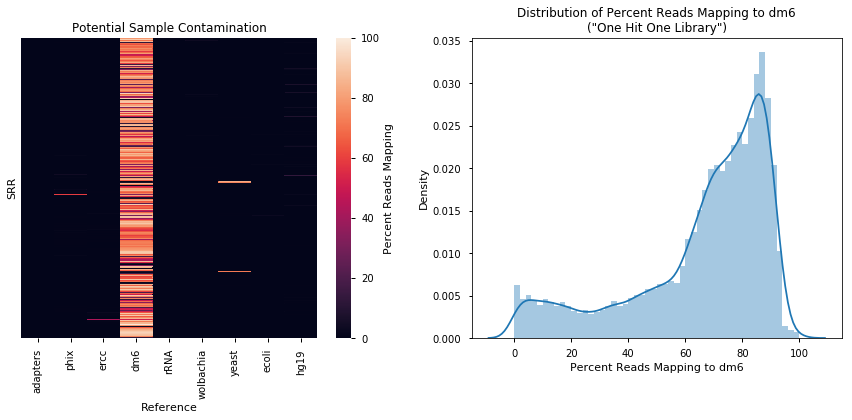

In [236]:
# Plot heatmap of one hit one species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
singles = data.loc[(slice(None), slice(None), 'one_hit_one_library_percent'), :]
singles.index = singles.index.droplevel(-1)

sns.heatmap(singles[REFERENCES], yticklabels=False, cbar_kws={'label': 'Percent Reads Mapping'}, ax=ax1)
ax1.set_title('Potential Sample Contamination');
ax1.set_ylabel('SRR');
ax1.set_xlabel('Reference');

# Plot distirbution of major categories
sns.distplot(singles.dm6, label='fly', ax=ax2)
plt.title('Distribution of Percent Reads Mapping to dm6\n("One Hit One Library")');
ax2.set_xlabel('Percent Reads Mapping to dm6')
ax2.set_ylabel('Density')
plt.tight_layout()

In [241]:
# For each sample figure out the major contributing source
majority = singles.apply(lambda x: x.argmax(), axis=1)

# output counts for number of samples where a contaminant was the major source.
one = majority.value_counts()
one['total'] = one.sum()
one = one.map(lambda x: '{:,}'.format(x)).to_frame()
one.columns = ['Number of Samples']
print('Read counts of samples whose majority of reads mapped to a reference.')
one

Read counts of samples whose majority of reads mapped to a reference.


,Number of Samples
dm6,"21,848"
yeast,204
hg19,50
ercc,36
adapters,17
rRNA,11
phix,11
ecoli,9
wolbachia,4
total,"22,190"


In [238]:
# How many samples have more than 60% of reads from dm6?
num_dm6 = '{:,}'.format((singles.dm6 >= 60).sum())
print('There are {} samples with more than 60% of reads mapping to dm6.'.format(num_dm6))

There are 15,973 samples with more than 60% of reads mapping to dm6.


In [239]:
# How many samples have 1% of reads aligning to another major source?
contaminant = (singles.filter(regex='[^(dm6 | rRNA | adapters | ercc)]') >= 1).any(axis=1)
num_samples_w_contaminant = contaminant.sum()

print('There were {:,} SRRs that showed at least '
      '1% of reads coming from another source.'.format(num_samples_w_contaminant))

There were 1,995 SRRs that showed at least 1% of reads coming from another source.


In [240]:
# Make output table of flags
cutoffs = {
    'wolbachia': lambda x: x >= 1,
    'hg19': lambda x: x >= 1,
    'yeast': lambda x: x >= 1,
    'ecoli': lambda x: x >= 1,
    'ercc': lambda x: x >= 0.01,
}

output = pd.DataFrame(index=singles.index)

# Flag samples with ≥1% of reads mapping to wolbachia
output['flag_wolbachia'] = False
output.loc[list(map(cutoffs['wolbachia'], singles.wolbachia)), 'flag_wolbachia'] = True

# Flag samples with ≥1% of reads mapping to human
output['flag_hg19'] = False
output.loc[list(map(cutoffs['hg19'], singles.hg19)), 'flag_hg19'] = True

# Flag samples with ≥1% of reads mapping to yeast
output['flag_yeast'] = False
output.loc[list(map(cutoffs['yeast'], singles.yeast)), 'flag_yeast'] = True

# Flag samples with ≥1% of reads mapping to ecoli
output['flag_ecoli'] = False
output.loc[list(map(cutoffs['ecoli'], singles.ecoli)), 'flag_ecoli'] = True

# Flag samples with ≥0.01% of reads mapping to ERCC
output['flag_ercc'] = False
output.loc[list(map(cutoffs['ercc'], singles.ercc)), 'flag_ercc'] = True

# Coutput summary counts
output.sum().to_frame().rename(columns={0: 'Number Samples with Possible Contaminant'}).applymap(lambda x: '{:,}'.format(x))

,Number Samples with Possible Contaminant
flag_wolbachia,276
flag_hg19,959
flag_yeast,344
flag_ecoli,178
flag_ercc,"4,962"


### Summary 

One hit one library reads align to one location in one reference. All analyzed samples are annotated as D. melanogaster, therefore I expect that the majority of reads will map to the D. melanogaster reference. Indeed, the majority of SRR map mostly to the dm6 reference, with {{num_dm6}} samples having at least 60% of reads mapping to dm6 reference. dm6 was the reference where the majority reads mapped in {{one.loc['dm6', 'Number of Samples']}} samples, while there were {{one.loc['hg19', 'Number of Samples']}} samples that mostly mapped to human.

## Multi Hit Multi Library

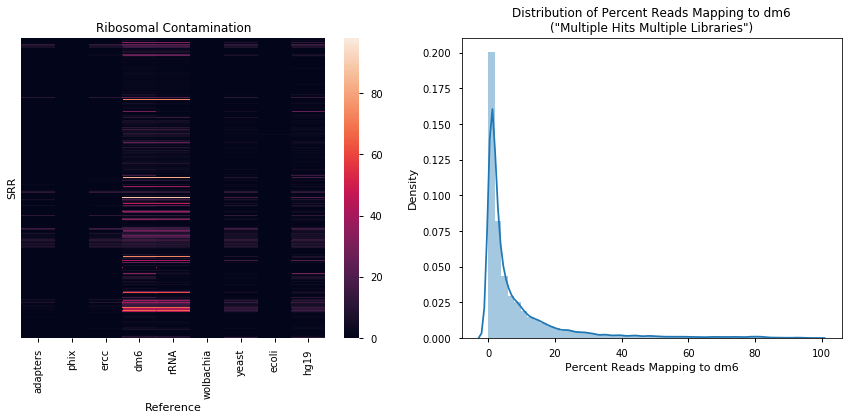

In [103]:
# Plot heatmap of multi hit multi species
multiMulti = data.loc[(slice(None), slice(None), 'multiple_hits_multiple_libraries_percent'), :]
multiMulti.index = multiMulti.index.droplevel(-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
sns.heatmap(multiMulti[REFERENCES], yticklabels=False, ax=ax1)
ax1.set_title('Ribosomal Contamination');
ax1.set_ylabel('SRR');
ax1.set_xlabel('Reference');

sns.distplot(multiMulti.dm6, ax=ax2)
ax2.set_title('Distribution of Percent Reads Mapping to dm6\n("Multiple Hits Multiple Libraries")');
ax2.set_xlabel('Percent Reads Mapping to dm6')
ax2.set_ylabel('Density')

plt.tight_layout()

In [296]:
# Create indicator variable showing rRNA contamination

# Get cutoffs
moderate_rRNA = ((multiMulti.dm6 >= 20) & (multiMulti.rRNA >= 20))
high_rRNA = ((multiMulti.dm6 >= 60) & (multiMulti.rRNA >= 60))
extreme_rRNA = ((multiMulti.dm6 >= 80) & (multiMulti.rRNA >= 80))

# Map to their meaning
mapper = {
    0: 'Low or No rRNA contamination (< 20%)', 
    1: 'Moderate rRNA contamination (≥ 20%)', 
    2: 'High rRNA contamination (≥ 60%)', 
    3: 'Extreme rRNA contamination (≥ 80%)',
    'total': 'Total'
}

# Build table
output['indicator_rRNA_contamination'] = 0
output.loc[moderate_rRNA, 'indicator_rRNA_contamination'] = 1
output.loc[high_rRNA, 'indicator_rRNA_contamination'] = 2
output.loc[extreme_rRNA, 'indicator_rRNA_contamination'] = 3

# Count the number of samples with different indicators
num_rRNA = (output.indicator_rRNA_contamination > 0).sum()
alot_rRNA = (output.indicator_rRNA_contamination >= 2).sum()
print('There were {:,} samples with signs of rRNA contamination'.format(num_rRNA))
two = output.indicator_rRNA_contamination.value_counts()
two['total'] = two.sum()
two = two.to_frame()
two.index = two.index.map(lambda x: mapper[x])
two = two.applymap(lambda x: '{:,}'.format(x))
two

There were 2,463 samples with signs of rRNA contamination


,indicator_rRNA_contamination
Low or No rRNA contamination (< 20%),"19,727"
Moderate rRNA contamination (≥ 20%),"2,005"
High rRNA contamination (≥ 60%),319
Extreme rRNA contamination (≥ 80%),139
Total,"22,190"


### Summary

I could get an estimate of rRNA contamination by looking at reads that are multiple hits to multiple libraries. There are {{'{:,}'.format(num_rRNA)}} samples with signs of rRNA contamination. Of these {{'{:,}'.format(alot_rRNA)}} samples had more than 60% reads mapping to the ribosomal RNAs. 

## Output Table

In [298]:
output.to_pickle('../../output/contamination_downstream_analysis.pkl')
output.head()

,,flag_wolbachia,flag_hg19,flag_yeast,flag_ecoli,flag_ercc,indicator_rRNA_contamination
srx,srr,,,,,,
DRX000774,DRR001177,False,False,False,False,False,0
DRX000775,DRR001178,False,False,False,False,False,0
DRX000998,DRR001444,False,False,False,False,False,0
DRX000999,DRR001445,False,False,False,False,False,0
DRX001000,DRR001446,False,False,False,False,False,0
